In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from scipy.optimize import curve_fit

%matplotlib inline


# PMFs, PDFs, CDFs and All That

Alphabet soup? Kinda. But these are the terms that are used in the business, so get used to it!

When dealing with random events and measurements it's important to be clear about the kinds of things that can happen and their relative likelihood. These concepts (PMF, PDF, CDF) help to understand and clarify the relationships between the many different ways things can be "random".

Let's start with the simplest cases: discrete events. This would be things like the roll of a die, or the flipping of a coin. In each case the outcome is one of a countable set of possible states (e.g., heads, tails, 1, 2, ... 6). Each of these outcomes may have a different probability. The distribution of probabilities among the outcomes is the "Probability Mass Function (PMF)".

For a fair coin, the probability mass function would be simply:

* Heads: 0.5
* Tails: 0.5

It's just a list of the possible outcomes, along with the probability of each. We can use the probability mass function to estimate the likelihood of various possibilities. 

## Example:

Since the simplest example of a PMF is the probability of a flipped coin landing on "heads" or "tails" we can work out the chances of seeing a certain number of heads or tails in a series of coin flipping experiments. Suppose we have a coin and we're not *sure* if it's fair. Let's flip it a bunch of times and see how many heads and tails we get. Can we tell from the number of heads and tails whether the coin is fair? To help us think about this I've cooked up a python function that flips coins using the built-in random number generator:


In [31]:
def flipCoins(N, p=0.5):
    """
    Simulate flipping a coin N times. Return the number of "heads". If p is not specified,
    the probability of "heads" on any given flip is 50%. Otherwise, the probability of "heads"
    is p.
    """
    return np.count_nonzero(np.random.rand(N)<p)

print("flip 100 coins, Nheads = ", flipCoins(100))
print("flip 1000 coins, Nheads = ", flipCoins(1000))
print("flip 10000 coins, Nheads = ", flipCoins(10000))
print("flip 100000 coins, Nheads = ", flipCoins(100000))

flip 100 coins, Nheads =  53
flip 1000 coins, Nheads =  529
flip 10000 coins, Nheads =  4940
flip 100000 coins, Nheads =  50052


Of course, every time you run this cell, you'll get slightly different results (since flipping a coin is, after all, random!). However you should notice that the larger the number of flips the smaller the *relative* deviation from the "fair coin" result. Can we quantify this? Sure! Let's do an experiment. Flip N coins, over and over, and compute the fraction of the time we get heads. To make this work we need to use a python *dictionary* which is a simple database of key-value pairs. In this case the "key" will be the number of heads, and the value will be a *count* of the number of times we got that number of heads.

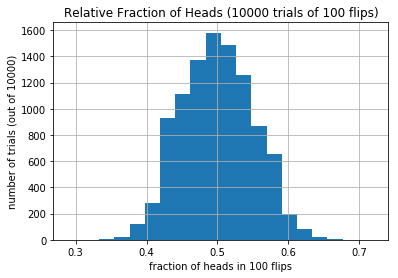

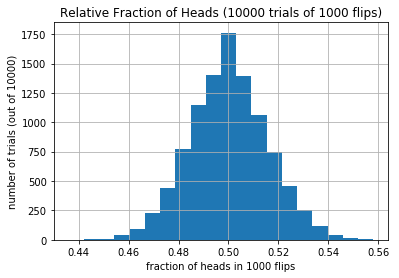

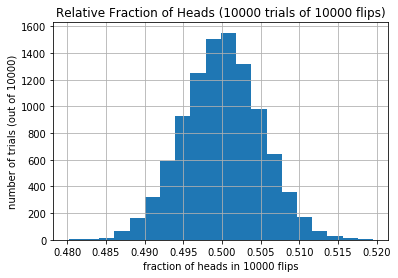

In [53]:
def buildAFlippingHistogram(M, N=100, p=0.5):
    """
    Flip N coins M times and create a histogram of the fraction of flips that are "heads"
    """
    
    results=[]
    
    for i in range(M):
        results.append(flipCoins(N,p)/N)

    pl.figure()
    pl.hist(results,20)
    pl.title("Relative Fraction of Heads ({0} trials of {1} flips)".format(M, N))
    pl.xlabel("fraction of heads in {0} flips".format(N))
    pl.ylabel("number of trials (out of {0})".format(M))
    pl.grid()
    
    

#
# Let's create 3 histograms with 100, 1000, and 10000 trials
#

buildAFlippingHistogram(10000,100,0.5)
buildAFlippingHistogram(10000,1000,0.5)
buildAFlippingHistogram(10000,10000,0.5)
    

What do you notice about these histograms? If you look carefully you'll see that the larger the number of flips the closer to 50% of the flips are heads. Does this make sense? We'll find out later exactly how this comes about and how to estimate the size of the effect mathematically. As a rule of thumb, if you *count* a number of events that are occuring randomly, the standard deviation of the count is typically something like the square root of the count. Does this rule compare reasonably with the results you see here? What do you think is the approximage PMF for this coin?

# Dictionaries to estimate PMFs

A python dictionary is a simple data structure used to track values by "key". Here's an example involving fruits. Suppose we pull 14 fruits out of a basket at random. We don't know how many of each type of fruit is *in* the basket, but suppose there's a lot (and that taking a few out doesn't significantly affect the chance of pulling out any particular type). We can use a dictionary to keep track of the types of fruit we get:

In [82]:
d={'orange':2, 'apple':5, 'grape':7}

print(d['orange'])

2


Dictionaries have some useful methods for inspecting and iterating over their contents. See examples below. Note in particular how you can use a dictionary to keep track of the counts of various categories and produce an estimated PMF based on a finite observation.

In [83]:
print("Getting keys and values from dict:\n")

print("keys:", list(d.keys()))
print("values:", list(d.values()))
print("items:",list(d.items()))

print("\nIterating through a dict's items:")
for k,v in d.items():
    print("key:",k,"value:",v)
print("\nDoing math on values (e.g., getting the sum of all values)")

num_fruits = np.array(list(d.values())).sum()
print("Total number of fruits:", num_fruits)

print("\nComputing the Fruit PMF.")
pmfDict = {}
for k,v in d.items():
    pmfDict[k]=v/num_fruits
    
print("\nPMF", pmfDict)

Getting keys and values from dict:

keys: ['orange', 'apple', 'grape']
values: [2, 5, 7]
items: [('orange', 2), ('apple', 5), ('grape', 7)]

Iterating through a dict's items:
key: orange value: 2
key: apple value: 5
key: grape value: 7

Doing math on values (e.g., getting the sum of all values)
Total number of fruits: 14

Computing the Fruit PMF.

PMF {'orange': 0.14285714285714285, 'apple': 0.35714285714285715, 'grape': 0.5}


So we have about a 14% chance of oranges, a 36% chance of apples and a 50% chance of grapes based on our small sample. Can you use our coin flipping experiment to estinage the range of probabilities you'd be likely to see if you repeated this experiment many times?

# PDFs

A PDF is similar to a PMF execept that the variable in question is continuous rather than discrete. Because of this it's not possible to say what the probability is of any specific outcome, but one must think about the probability either for a small *range* of outcome values, or in terms of a *probability* *density* (probability per unit outcome value). For example, suppose you spin a pointer that has an equal chance of stopping at any angle. You cannot say what's the chance of landing at $45^\circ$. That's zero! You *can* say the chance of landing between $44.5^\circ$ and $45.5^\circ$, that's 1/360. So the PDF would be uniform (for all angles) and equal to 1/360 *per* *degree*. PDFs do not have to be uniform (most are not!). They can have many different functional forms.